### Example for DNN with the IMDB dataset (including regularization)

Loading the dataset and checking dimensions

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np

from tensorflow.keras import models, layers

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv("tweet_emotions.csv")

df = df.drop(['tweet_id'], axis=1)

df.head()


2023-04-01 17:23:21.984562: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-01 17:23:22.018369: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-01 17:23:22.019221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 17:23:22.702285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [2]:
df.shape


(40000, 2)

In [3]:
labels = df['sentiment'].astype('category').cat.categories.tolist()
replace_map = {'sentiment' : {k: v for k,v in zip(labels, list(range(1,len(labels)+1)))}}

df.replace(replace_map, inplace=True)
df.head()#


df_train, df_test = train_test_split(df, test_size = 0.25, random_state=2022)

print(df_train.shape)
print(df_test.shape)

(train_data, train_labels), (test_data, test_labels) = (df_train['content'],df_train['sentiment']),(df_test['content'],df_test['sentiment'])
train_data[0]
df.head()


(30000, 2)
(10000, 2)


,sentiment,content
0,3,@tiffanylue i know i was listenin to bad habi...
1,11,Layin n bed with a headache ughhhh...waitin o...
2,11,Funeral ceremony...gloomy friday...
3,4,wants to hang out with friends SOON!
4,9,@dannycastillo We want to trade with someone w...


In [4]:
print(max(train_labels))
train_labels, test_labels = to_categorical(train_labels), to_categorical(test_labels)
print(train_labels)

13
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
tokenizer = Tokenizer(oov_token='<UNK>')
#tokenizer = Tokenizer(oov_token='<OOV>', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')

#ola = pd.concat([train_data, test_data], axis=0)
#ola.head()
train_data.head()
tokenizer.fit_on_texts(pd.concat([train_data, test_data], axis=0))
#
tokenizer.document_count
#tokenizer.word_index
#tokenizer.word_index['towards']

40000

Exploring and pre-processing the dataset

In [6]:
sequences_train = tokenizer.texts_to_sequences(train_data)
sequences_test = tokenizer.texts_to_sequences(test_data)
#print(train_data.head())
#print(train_data[0])
#print(sequences_train[0])

#reverse
reverse_test = tokenizer.sequences_to_texts(sequences_train)
#print(reverse_test[0])

m1 = max([max(sequence) for sequence in sequences_train])
m2 = max([max(sequence) for sequence in sequences_test])
m3 = max(m1,m2) + 1
print(m1)
print(m2)
print(m3)

40506
48998
48999


In [7]:
def vectorize_sequences(sequences, dimension=m3):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(sequences_train)
x_test = vectorize_sequences(sequences_test)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

print(x_train)
print(len(x_train[0]))
print(len(x_train[100]))

print(len(x_train))
print(len(x_test))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
48999
48999
30000
10000


In [8]:
x_val = x_train[:20000]
partial_x_train = x_train[20000:]
y_val = y_train[:20000]
partial_y_train = y_train[20000:]


chosen_model = 5

Defining the model structure

In [9]:
if chosen_model == 1:

    hidden = 16
    
    model = models.Sequential()
    model.add(layers.Dense(hidden, activation='relu', input_shape=(m3,)))
    model.add(layers.Dense(hidden, activation='relu'))
    model.add(layers.Dense(14, activation='softmax'))


Training the model and plotting errors along the process

In [10]:
if chosen_model == 1:
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    model.summary()
    
    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=20,
                        batch_size=512,
                        validation_data=(x_val, y_val))

In [11]:
if chosen_model == 1:
    history_dict = history.history
    acc_values = history_dict['acc'] 
    val_acc_values = history_dict['val_acc']
    epochs = range(1, len(acc_values) + 1)
    plt.plot(epochs, acc_values, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()


In [12]:
if chosen_model == 1:
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss']
    
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Predicting for the test set and calculating errors

In [13]:
if chosen_model == 1:
    preds = model.predict(x_test) # probabilities
    class_preds = preds > 0.5
    
    print(preds[0:5])
    class_preds[0:5]

In [14]:
if chosen_model == 1:
    results = model.evaluate(x_test, y_test, verbose = 0)
    results

Overfitting - controlling capacity of the model

In [15]:
if chosen_model == 2:
    hidden = 4
    
    model2 = models.Sequential()
    model2.add(layers.Dense(hidden, activation='relu', input_shape=(m3,)))
    model2.add(layers.Dense(hidden, activation='relu'))
    model2.add(layers.Dense(14, activation='softmax'))
    
    model2.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    history2 = model2.fit(partial_x_train,
                        partial_y_train,
                        epochs=20,
                        batch_size=512,
                        validation_data=(x_val, y_val))
    
    results2 = model2.evaluate(x_test, y_test, verbose = 0)
    print(results2)
    
    history_dict2 = history2.history
    loss_values2 = history_dict2['loss'] 
    val_loss_values2 = history_dict2['val_loss']
    epochs = range(1, len(loss_values2) + 1)

    
    plt.plot(epochs, loss_values2, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values2, 'b', label='Validation loss')
    plt.title('Training and validation loss (4 hidden neurons)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [16]:
if chosen_model == 3:
    hidden = 64
    
    model3 = models.Sequential()
    model3.add(layers.Dense(hidden, activation='relu', input_shape=(m3,)))
    model3.add(layers.Dense(hidden, activation='relu'))
    model3.add(layers.Dense(14    , activation='softmax'))
    
    model3.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    history3 = model3.fit(partial_x_train,
                        partial_y_train,
                        epochs=20,
                        batch_size=512,
                        validation_data=(x_val, y_val))
    
    
    results3 = model3.evaluate(x_test, y_test, verbose = 0)
    print(results3)
    
    history_dict3 = history3.history
    loss_values3 = history_dict3['loss'] 
    val_loss_values3 = history_dict3['val_loss']
    epochs = range(1, len(loss_values3) + 1)

    
    plt.plot(epochs, loss_values3, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values3, 'b', label='Validation loss')
    plt.title('Training and validation loss (64 hidden neurons)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

L2 regularization 

In [17]:
if chosen_model == 4:
    hidden = 16
    
    model_l2 = models.Sequential()
    model_l2.add(layers.Dense(hidden, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                           input_shape=(m3,)))
    model_l2.add(layers.Dense(hidden, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_l2.add(layers.Dense(14, activation='softmax'))
    
    model_l2.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    history_l2 = model_l2.fit(partial_x_train,
                        partial_y_train,
                        epochs=20,
                        batch_size=512,
                        validation_data=(x_val, y_val))
    
    history_l2_dict = history_l2.history
    loss_values_l2 = history_l2_dict['loss'] 
    val_loss_values_l2 = history_l2_dict['val_loss']
    epochs = range(1, len(loss_values_l2) + 1)
    
    plt.plot(epochs, loss_values_l2, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values_l2, 'b', label='Validation loss')
    plt.title('Training and validation loss - L2 regularizer')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    results_l2 = model_l2.evaluate(x_test, y_test, verbose = 0)
    results_l2

Dropout

Epoch 1/10
40/40 [==============================] - 8s 182ms/step - loss: 2.5021 - acc: 0.1726 - val_loss: 2.3347 - val_acc: 0.2242
Epoch 2/10
40/40 [==============================] - 2s 52ms/step - loss: 2.3207 - acc: 0.2019 - val_loss: 2.2194 - val_acc: 0.2650
Epoch 3/10
40/40 [==============================] - 2s 49ms/step - loss: 2.2390 - acc: 0.2208 - val_loss: 2.1595 - val_acc: 0.2758
Epoch 4/10
40/40 [==============================] - 2s 53ms/step - loss: 2.1765 - acc: 0.2387 - val_loss: 2.1236 - val_acc: 0.2859
Epoch 5/10
40/40 [==============================] - 2s 51ms/step - loss: 2.1058 - acc: 0.2647 - val_loss: 2.0801 - val_acc: 0.2873
Epoch 6/10
40/40 [==============================] - 2s 51ms/step - loss: 2.0451 - acc: 0.2863 - val_loss: 2.0494 - val_acc: 0.3079
Epoch 7/10
40/40 [==============================] - 2s 50ms/step - loss: 1.9909 - acc: 0.3163 - val_loss: 2.0216 - val_acc: 0.3207
Epoch 8/10
40/40 [==============================] - 2s 50ms/step - loss: 1.9338 - 

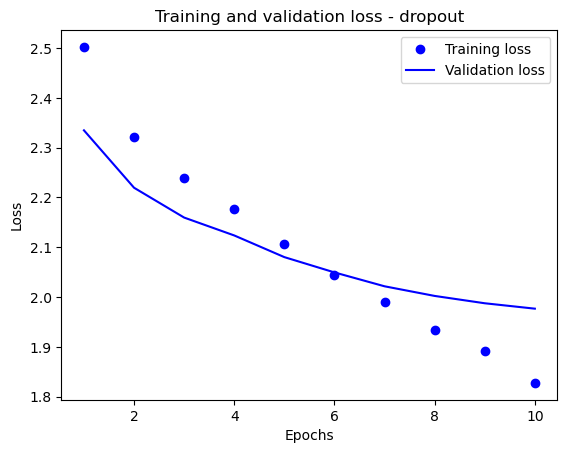

In [21]:
if chosen_model == 5:   
    hidden = 16
    
    model_dr = models.Sequential()
    model_dr.add(layers.Dense(hidden, activation='relu', input_shape=(m3    ,)))
    model_dr.add(layers.Dropout(0.5))
    model_dr.add(layers.Dense(hidden, activation='relu'))
    model_dr.add(layers.Dropout(0.5))
    model_dr.add(layers.Dense(14, activation='softmax'))
    
    model_dr.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    history_dr = model_dr.fit(partial_x_train,
                        partial_y_train,
                        epochs=10,
                        batch_size=512,
                        validation_data=(x_val, y_val))
    
    history_dr_dict = history_dr.history
    loss_values_dr = history_dr_dict['loss'] 
    val_loss_values_dr = history_dr_dict['val_loss']
    epochs = range(1, len(loss_values_dr) + 1)
    
    plt.plot(epochs, loss_values_dr, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values_dr, 'b', label='Validation loss')
    plt.title('Training and validation loss - dropout')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    results_dr = model_dr.evaluate(x_test, y_test, verbose = 0)
    results_dr

Early Stopping

In [ ]:
if chosen_model == 6:
    hidden = 128
    
    model = models.Sequential()
    model.add(layers.Dense(hidden, activation='relu', input_shape=(m3,)))
    model.add(layers.Dense(hidden, activation='relu'))
    model.add(layers.Dense(14, activation='softmax'))
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience= 5, verbose= True, mode='auto')
    
    callbacks = [early]
    history_es = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=20,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        callbacks = callbacks)
    
    history_dict_es = history_es.history
    loss_values_es = history_dict_es['loss'] 
    val_loss_values_es = history_dict_es['val_loss']
    epochs = range(1, len(loss_values_es) + 1)
    
    plt.plot(epochs, loss_values_es, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values_es, 'b', label='Validation loss')
    plt.title('Training and validation loss (early stopping)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    results_es = model.evaluate(x_test, y_test, verbose = 0)
    results_es